In [123]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pandas_profiling as pp
import seaborn as sns
import warnings
import os
from scipy.stats import ttest_ind, f_oneway, kruskal
from scipy.stats import chi2_contingency

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)



In [124]:
# Leitura do dataset refinado
diretorio_acidentes = 'data/refined/acidentes_recife_normalizados.csv'
df_acidentes = pd.read_csv(diretorio_acidentes, sep=',', parse_dates=['data'])
       

In [125]:
df_acidentes.head(3)

,Unnamed: 0,data,hora,natureza_acidente,situacao,bairro,endereco,complemento,bairro_cruzamento,tipo,descricao,Protocolo,auto_bin,moto_bin,ciclom_bin,ciclista_bin,pedestre_bin,onibus_bin,caminhao_bin,viatura_bin,outros_bin,vitimas_bin,vitimasfatais_bin,dia_da_semana,mes,ano,estacao
0,0,2021-01-01,19:44:00,Não fatal,FINALIZADA,MADALENA,RUA BENFICA,EM FRENTE AO EXTRA NA SAIDA,MADALENA,COLISÃO FRONTAL,NaN,NaN,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday,1.0,2021.0,Verão
1,1,2021-01-01,23:15:40,Não fatal,FINALIZADA,VÁRZEA,AV CAXANGA,EM FRENTE A UPA DA CAXANGA,VÁRZEA,COLISÃO TRASEIRA,NaN,NaN,0.25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday,1.0,2021.0,Verão
2,2,2021-01-02,10:54:00,Não fatal,FINALIZADA,VASCO DA GAMA,RUA RESPLENDOR,AO LADO DO COLEGIO ADERBAL GALVÃO EM FRE...,VASCO DA GAMA,COLISÃO COM CICLISTA,NaN,NaN,0.00,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Saturday,1.0,2021.0,Verão


# Estatísticas descritivas

In [148]:
df_acidentes.describe()

,Unnamed: 0,data,descricao,auto_bin,moto_bin,ciclom_bin,ciclista_bin,pedestre_bin,onibus_bin,caminhao_bin,viatura_bin,outros_bin,vitimas_bin,vitimasfatais_bin,mes,ano,contagem_acidentes
count,36615.000000,36447,0.0,36615.000000,36615.000000,36615.000000,36615.000000,36615.000000,36615.000000,36615.000000,36615.000000,36615.000000,36615.000000,36615.000000,36447.000000,36447.000000,36615.0
mean,18307.983258,2023-04-25 14:51:57.886245632,NaN,0.008521,0.003455,0.001202,0.003127,0.004390,0.008712,0.000068,0.000027,0.000048,0.000109,0.000055,6.744067,2022.797350,1.0
min,0.000000,2021-01-01 00:00:00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2021.000000,1.0
25%,9154.500000,2023-02-20 00:00:00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2023.000000,1.0
50%,18308.000000,2023-06-11 00:00:00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,2023.000000,1.0
75%,27461.500000,2023-09-27 00:00:00,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,2023.000000,1.0
max,36615.000000,2024-12-31 00:00:00,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,2024.000000,1.0
std,10570.012903,NaN,NaN,0.047351,0.029936,0.034645,0.029047,0.036669,0.067681,0.006128,0.005226,0.006532,0.008467,0.006662,3.440316,0.542574,0.0


# Testes de Hipótese

#### Feriados e Acidentes
Hipótese nula (H0): Não existe relação entre feriados e aumentos no índice de acidentes.

Hipótese alternativa (H1): Existe relação entre feriados e aumentos no índice de acidentes.

<Axes: xlabel='num_acidentes', ylabel='Density'>

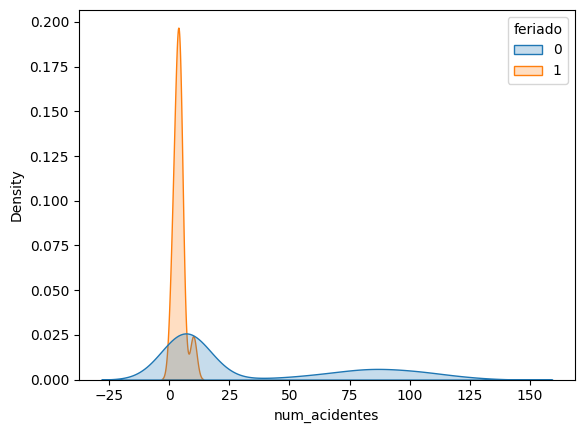

In [130]:
# Definindo uma lista de feriados principais
feriados = [
    "2021-01-01", "2021-03-02", "2021-04-02", "2021-04-21", 
    "2021-05-01", "2021-06-03", "2021-06-24", "2021-09-07", 
    "2021-10-12", "2021-11-02", "2021-11-15", "2021-12-25"
]

df_acidentes_grouped = df_acidentes.groupby(['data']).size().rename('num_acidentes').reset_index()

# Marcando feriados no dataframe
df_acidentes_grouped['feriado'] = df_acidentes_grouped['data'].isin(feriados).astype(int)

sns.kdeplot(data = df_acidentes_grouped, x = 'num_acidentes', hue='feriado', common_norm= False, fill=True)

In [147]:
from scipy.stats import ks_2samp

ks_2samp(df_acidentes_grouped.query('feriado')['num_acidentes'], df_acidentes_grouped.query('feriado == 0')['num_acidentes'] )

KstestResult(statistic=0.9665738161559888, pvalue=0.0, statistic_location=2, statistic_sign=1)

Nossa análise dos dados de trânsito mostrou que mais acidentes ocorrem durante os feriados do que em dias normais. 

#### Tipo de veículo e quantidade de acidentes.
Hipótese Nula (H0): Não existe diferença significativa na estação do tipo e na natureza do acidente.

Hipótese Alternativa (H1): A diferença na estação do tipo e na natureza do acidente é significativa.

In [133]:
# Criar uma tabela de contingência
tabela_contingencia = pd.crosstab(df_acidentes['natureza_acidente'], df_acidentes['estacao'])

# Realizar o teste qui-quadrado
chi2, p_value, dof, expected = chi2_contingency(tabela_contingencia)

print(f"Chi-squared: {chi2}")
print(f"P-value: {p_value}")




Chi-squared: 154.93829602645198
P-value: 6.982563682222359e-31


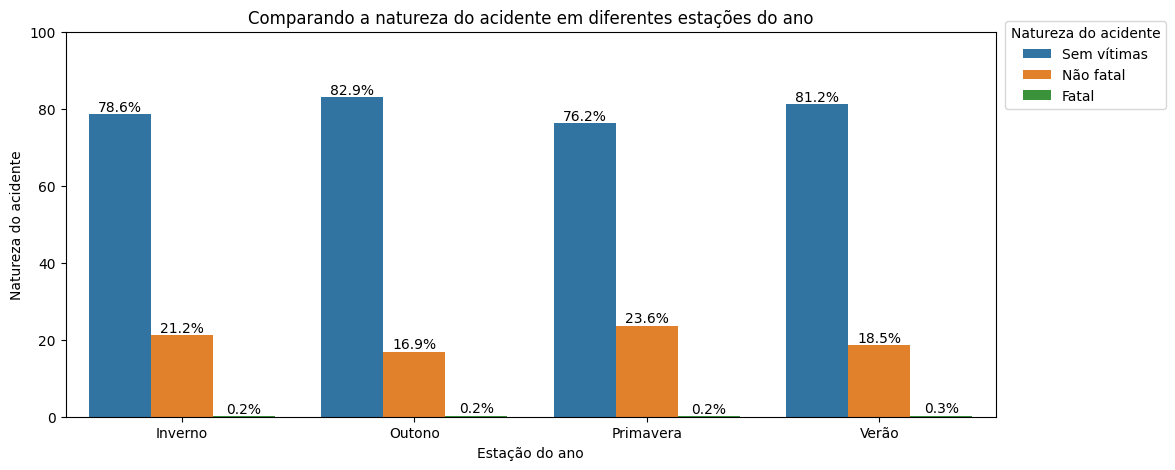

In [149]:
fig, ax = plt.subplots(1, figsize=(12, 5))

attrition_by_card = (df_acidentes.groupby('estacao')['natureza_acidente'].value_counts(normalize=True)*100).rename('Percentage').reset_index()
sns.barplot(data=attrition_by_card, x='estacao', y='Percentage', hue='natureza_acidente', ax=ax)
ax.set_title('Comparando a natureza do acidente em diferentes estações do ano')
ax.set_xlabel('Estação do ano')
ax.set_ylabel('Natureza do acidente')
ax.set_ylim(0, 100)
ax.legend(title = 'Natureza do acidente', loc=(1.01, 0.8))
for container in ax.containers: # Displaying values at bars
    ax.bar_label(container, fmt='%.1f%%')

Nossa análise estatística mostrou uma pequena relação entre as estações do ano e a natureza dos acidentes de trânsito em Recife. Isso significa que certos tipos de acidentes tendem a ocorrer com mais frequência em algumas estações do ano do que em outras. No inverno e na primavera temos uma quantidade um pouco maior de acidentes não fatais.